In [13]:
#imports
#numpy,pandas,scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

# preprocessing
from sklearn import preprocessing


#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier



#model metrics
from sklearn.metrics import mean_squared_error # regression
from sklearn.metrics import r2_score # regression
from sklearn.metrics import cohen_kappa_score # classification
from sklearn.metrics import accuracy_score # classification
from sklearn.metrics import classification_report # sensitivity

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix # classification
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn import svm, datasets
from sklearn.utils.multiclass import unique_labels
from imblearn.over_sampling import SMOTE


#cross validation
from sklearn.model_selection import train_test_split

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve


In [23]:
# load data
rawData = pd.read_csv('creditSUB.csv', header =0)
rawData = rawData[rawData.columns[1:len(rawData.columns)]]


In [24]:
# select the features from the dataet
rawData = rawData[['LIMIT_BAL', 'MEAN_DELAY', 'EDUCATION', 'AGE',
                              'RATIO_CREDIT_SEP', 'MEAN_BILL', 'MEAN_PAID', 
                              'PAID_SEP','BILL_SEP','DEFAULT']]

# select features for training
indepVar = rawData.drop('DEFAULT', axis=1)

# dependent variable
depVar = rawData['DEFAULT']

0    23364
1     6636
Name: DEFAULT, dtype: int64

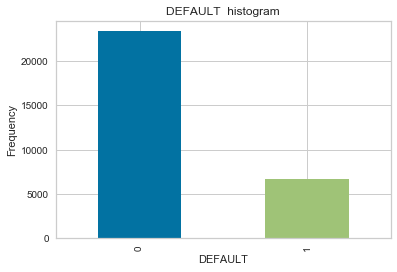

In [25]:
# check the balans of the dataset and rebalance if necessary
pd.value_counts(rawData['DEFAULT']).plot.bar()
plt.title('DEFAULT  histogram')
plt.xlabel('DEFAULT')
plt.ylabel('Frequency')
rawData['DEFAULT'].value_counts()

# Make sure you do it the right way: oversampling on only the training data. 

In [26]:
print('Summary of feature sample')
indepVar.head()

Summary of feature sample


,LIMIT_BAL,MEAN_DELAY,EDUCATION,AGE,RATIO_CREDIT_SEP,MEAN_BILL,MEAN_PAID,PAID_SEP,BILL_SEP
0,20000,-0.333333,2,24,0.195650,1284.000000,114.833333,0,3913
1,120000,0.500000,2,26,0.022350,2846.166667,833.333333,0,2682
2,90000,0.000000,2,34,0.324878,16942.166667,1836.333333,1518,29239
3,50000,0.000000,2,37,0.939800,38555.666667,1398.000000,2000,46990
4,50000,-0.333333,2,57,0.172340,18223.166667,9841.500000,2000,8617


In [27]:
np.random.seed(1)
# generate a dataframe that functions as a trainingset
X_train, X_test, y_train, y_test = train_test_split(indepVar, depVar, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(21000, 9) (21000,)
(9000, 9) (9000,)


By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable.

In [28]:
# balance the trainingdata
smote = SMOTE(random_state = 4)
X_sm, y_sm = smote.fit_sample(X_train, y_train)

print(X_sm.shape, y_sm.shape)


(32728, 9) (32728,)


In [29]:
# Choose your model
modelSVM = svm.SVC(gamma='scale')

# Fitting and Scoring
modelSVM.fit(X_sm, y_sm)
print(cross_val_score(modelSVM, X_sm, y_sm, cv=5))
print(modelSVM.score(X_sm,y_sm))

[0.75618698 0.75313168 0.75511763 0.75908952 0.76757335]
0.9481789293571254


In [30]:
# make predictions with the Random Forest for model 1
predictionsSVM = modelSVM.predict(X_test)
confusionMatrixSVM = confusion_matrix(y_test,predictionsSVM)
print(confusionMatrixSVM)

[[6076  924]
 [1496  504]]


In [31]:
# print the confusion matrix
confusionMatrixSVM = pd.crosstab(y_test, predictionsSVM, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusionMatrixSVM)

# print accuracy and kappa
accuracySVM = accuracy_score(y_test, predictionsSVM)
kappaSVM = cohen_kappa_score(y_test, predictionsSVM)
print('ACCURACY: %.3f' % accuracySVM)
print('KAPPA: %.3f' % kappaSVM)

# print accuracy, kappa and other statistics
print(classification_report(y_test, predictionsSVM))

Predicted     0     1   All
Actual                     
0          6076   924  7000
1          1496   504  2000
All        7572  1428  9000
ACCURACY: 0.731
KAPPA: 0.134
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      7000
           1       0.35      0.25      0.29      2000

   micro avg       0.73      0.73      0.73      9000
   macro avg       0.58      0.56      0.56      9000
weighted avg       0.70      0.73      0.71      9000



<b>Precision</b> means the percentage of your results which are relevant. It is the ratio of correctly predicted positive observations to the total predicted positive observations. 

<b>Recall</b> refers to the percentage of total relevant results correctly classified by your algorithm. So Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.

<b>F1 Score</b> is needed when you want to seek a balance between Precision and Recall. We have previously seen that accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much. Whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

source: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [12]:
# print feature importance of RF
# list of column names from original data
cols = indepVar.columns
# feature importances from random forest fit rf
rank = modelSVM.feature_importances_
# form dictionary of feature ranks and features
features_dict = dict(zip(np.argsort(rank),cols))
# the dictionary key are the importance rank; the values are the feature name
features_dict

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [72]:
# visualize the errrors of the best model, so make a dataframe of the predictions
# concatinate this dataframe with 
df = pd.DataFrame(modelSVM.predict(X_test))


df.rename(columns={0:'Predictions'}, inplace = True)
df.head()

,Predictions
0,0
1,1
2,0
3,1
4,0


In [80]:
temp = {'DEFAULT': y_test, 'Predictions' : predictionsSVM}
df_temp = pd.DataFrame(data=temp)
df_temp.head()

,DEFAULT,Predictions
10747,0,0
12573,1,1
29676,0,0
8856,1,1
21098,0,0


In [105]:
result = pd.concat([df_temp, X_test], axis=1, sort=False)
result.head()

,DEFAULT,Predictions,LIMIT_BAL,MEAN_DELAY,RATIO_CREDIT_SEP,MEAN_BILL,MEAN_PAID,PAID_SEP,BILL_SEP,Prediction
10747,0,0,310000,0.000000,0.557329,98643.166667,4049.166667,8295,172772,0
12573,1,1,10000,-0.166667,0.003200,447.333333,501.666667,0,32,1
29676,0,0,50000,-0.833333,0.008600,22991.500000,15855.000000,0,430,0
8856,1,1,80000,2.500000,0.458112,39561.500000,1683.333333,3700,36649,1
21098,0,0,270000,0.833333,0.077700,19068.666667,1666.666667,0,20979,0


In [106]:
result['ERRORS'] = result.DEFAULT - result.Predictions
result.head()

,DEFAULT,Predictions,LIMIT_BAL,MEAN_DELAY,RATIO_CREDIT_SEP,MEAN_BILL,MEAN_PAID,PAID_SEP,BILL_SEP,Prediction,ERRORS
10747,0,0,310000,0.000000,0.557329,98643.166667,4049.166667,8295,172772,0,0
12573,1,1,10000,-0.166667,0.003200,447.333333,501.666667,0,32,1,0
29676,0,0,50000,-0.833333,0.008600,22991.500000,15855.000000,0,430,0,0
8856,1,1,80000,2.500000,0.458112,39561.500000,1683.333333,3700,36649,1,0
21098,0,0,270000,0.833333,0.077700,19068.666667,1666.666667,0,20979,0,0


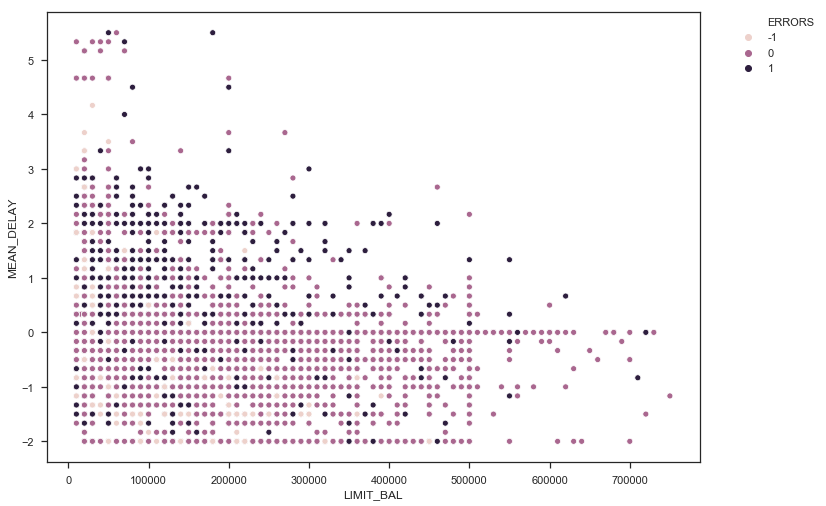

In [115]:
# make a figure 
x = result['LIMIT_BAL']
y = result['MEAN_DELAY']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="ticks")

sns.scatterplot(x, y, hue= 'ERRORS', data=result)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Put the legend out of the figure
